In [1]:
import numpy as np                # import numpy
import matplotlib.pyplot as plt   # import matplotlib, a python 2d plotting library
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from models import CNN, FC
from attacks import *
from train import eval

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [2]:
def find_transfer(source_model, target_model, data, attack, epsilon):
    adv_sample_count = 0.0
    adv_transfer_count = 0.0
    for x,y in data_loader:
        x,y = x.to(device), y.to(device)
        x = attack(x,y,source_model,epsilon)
        yhat_s = torch.argmax(source_model(x), dim=1)
        yhat_t = torch.argmax(target_model(x), dim=1)
        adv_s, adv_t = yhat_s!=y, yhat_t!=y
        adv_sample_count = adv_sample_count + torch.sum(adv_s)
        adv_transfer_count = adv_transfer_count + torch.sum(adv_s & adv_t)
    transfer_rate = adv_transfer_count/adv_sample_count
    return transfer_rate

In [3]:
test_data = torchvision.datasets.MNIST('../mnist_digits/', train=False, download=True,transform=torchvision.transforms.ToTensor())
data_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

In [6]:
#Creating a table dataframe:
columns = ['Model Architecture', 'Test Accuracy', 'Correlation', 'Attack Type', r'$\epsilon$', '% Transfer']
transfer_rates = pd.DataFrame(columns=columns)
models = [CNN, FC]
attacks = [FGSM_linf, PGD_linf, FGSM_l2, PGD_l2]
epsilons = [0.05, 0.1, 0.15, 0.2]
for model in models:
    for attack in attacks:
        for epsilon in epsilons:
            for corr in ['cor', 'dec']:
                model_name = model.__name__
                model_dir = 'saved_models/' + model_name + '/' + corr
                cls1, cls2 = model().to(device), model().to(device)
                cls1.load_state_dict(torch.load(model_dir+'1', map_location=device))
                cls2.load_state_dict(torch.load(model_dir+'2', map_location=device))
                accuracy = (eval(cls1, data_loader)+eval(cls2, data_loader)).item()
                accuracy = round(accuracy*100/2,2)
                #transfer_rate = (find_transfer(cls1, cls2, test_data, attack, epsilon)+find_transfer(cls2, cls1, test_data, attack, epsilon)).item()
                transfer_rate = find_transfer(cls1, cls2, test_data, attack, epsilon).item()
                #transfer_rate = round(transfer_rate*100/2,2)
                transfer_rate = round(transfer_rate*100,2)
                data = [[model_name, accuracy, corr, attack.__name__, epsilon, transfer_rate]]
                entry = pd.DataFrame(data=data, columns=columns)
                transfer_rates = transfer_rates.append(entry)
                print(entry)

  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                CNN          94.56         cor   FGSM_linf        0.05   

   % Transfer  
0       59.01  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                CNN          95.41         dec   FGSM_linf        0.05   

   % Transfer  
0       13.79  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                CNN          94.56         cor   FGSM_linf         0.1   

   % Transfer  
0       67.63  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                CNN          95.41         dec   FGSM_linf         0.1   

   % Transfer  
0       27.77  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                CNN          94.56         cor   FGSM_linf        0.15   

   % Transfer  
0       76.91  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0         

  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                 FC          96.16         dec    PGD_linf        0.15   

   % Transfer  
0       74.82  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                 FC          98.21         cor    PGD_linf         0.2   

   % Transfer  
0       98.07  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                 FC          96.16         dec    PGD_linf         0.2   

   % Transfer  
0       89.46  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                 FC          98.21         cor     FGSM_l2        0.05   

   % Transfer  
0       48.11  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0                 FC          96.16         dec     FGSM_l2        0.05   

   % Transfer  
0       20.97  
  Model Architecture  Test Accuracy Correlation Attack Type  $\epsilon$  \
0         

In [7]:
transfer_rates['Attack Type'] = transfer_rates['Attack Type'].replace('FGSM_linf', r'FGSM $\ell_\infty$')
transfer_rates['Attack Type'] = transfer_rates['Attack Type'].replace('FGSM_l2', r'FGSM $\ell_2$')
transfer_rates['Attack Type'] = transfer_rates['Attack Type'].replace('PGD_linf', r'PGD $\ell_\infty$')
transfer_rates['Attack Type'] = transfer_rates['Attack Type'].replace('PGD_l2', r'PGD $\ell_2$')
transfer_rates

,Model Architecture,Test Accuracy,Correlation,Attack Type,$\epsilon$,% Transfer
0,CNN,94.56,cor,FGSM $\ell_\infty$,0.05,59.01
0,CNN,95.41,dec,FGSM $\ell_\infty$,0.05,13.79
0,CNN,94.56,cor,FGSM $\ell_\infty$,0.10,67.63
0,CNN,95.41,dec,FGSM $\ell_\infty$,0.10,27.77
0,CNN,94.56,cor,FGSM $\ell_\infty$,0.15,76.91
...,...,...,...,...,...,...
0,FC,96.16,dec,PGD $\ell_2$,0.10,58.63
0,FC,98.21,cor,PGD $\ell_2$,0.15,83.43
0,FC,96.16,dec,PGD $\ell_2$,0.15,67.53
0,FC,98.21,cor,PGD $\ell_2$,0.20,91.47


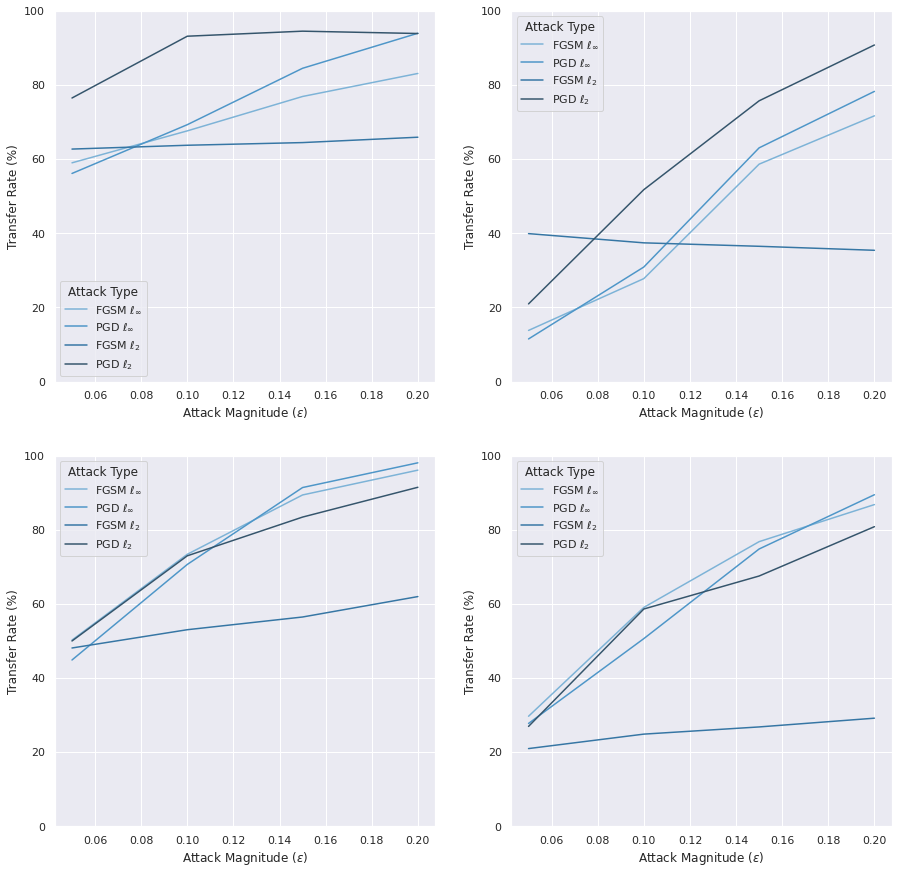

In [8]:
sns.set_theme()
fig, ax = plt.subplots(2,2, figsize=(15,15))

sns.lineplot(ax=ax[0,0], data=transfer_rates[(transfer_rates['Model Architecture'] == 'CNN') & (transfer_rates['Correlation'] == 'cor')], x=r'$\epsilon$', y='% Transfer', hue='Attack Type', palette='Blues_d')
sns.lineplot(ax=ax[0,1], data=transfer_rates[(transfer_rates['Model Architecture'] == 'CNN') & (transfer_rates['Correlation'] == 'dec')], x=r'$\epsilon$', y='% Transfer', hue='Attack Type', palette='Blues_d')
sns.lineplot(ax=ax[1,0], data=transfer_rates[(transfer_rates['Model Architecture'] == 'FC') & (transfer_rates['Correlation'] == 'cor')], x=r'$\epsilon$', y='% Transfer', hue='Attack Type', palette='Blues_d')
sns.lineplot(ax=ax[1,1], data=transfer_rates[(transfer_rates['Model Architecture'] == 'FC') & (transfer_rates['Correlation'] == 'dec')], x=r'$\epsilon$', y='% Transfer', hue='Attack Type', palette='Blues_d')

for i in range(len(ax)):
    for j in range(len(ax[0])):      
        ax[i,j].set_ylim(0,100)
        ax[i,j].set_xlabel(r'Attack Magnitude ($\epsilon$)')
        ax[i,j].set_ylabel('Transfer Rate (%)')



In [9]:
fig.savefig('all_transfer_rates.jpg', bbox_inches = 'tight', pad_inches = 0, format='jpg', dpi=600)